# Notes

## Motivation

As convolutional neural networks (CNNs) models have increased layers, training has become more difficult due to the degradation problem. This problem can be understood from the observation that networks have a difficulty learning an identity mapping, potentially accumulating errors as the networks get deeper. ResNets work to solve this issue by making an addition of identity, modeling an incremental change each layer to the hidden state of the previous layer:
$$
z_{t+1} = z_t + f(z_t, {\theta}_t)
$$
* $z_{t+1}$ represents the next hidden layer
* $z_t$ represents the current hidden layer
* $f(z, \theta)$ is the function at each layer with parameters $\theta$
* ${\theta}_t$ is the parameters of the current layer
---
Notice that this is simmilar to the Euler's method for solving differential equations with ${\Delta}t$ equal to 1:
$$
z_{t+{\Delta}t} = z_t + {\Delta}t*f(z_t, {\theta}_t)
$$
Re-arranging we can solve for the function:
$$
\dfrac{z_{t+{\Delta}t} - z_t}{{\Delta}t} = f(z_t, {\theta}_t)
$$

Euler's method for solving differential equations can work for short intervals, but with more steps the error will accumulate and increase. This can be related to error in a network's functional mapping increasing as the number of layers increases. Next we take the limit of ${\Delta}t$ going to zero:
$$
\lim_{{\Delta}t\to0}\dfrac{z_{t+{\Delta}t} - z_t}{{\Delta}t} = \lim_{{\Delta}t\to0}f(z_t, {\theta}_t)
$$

Solving for this limit leaves us with a differential equation modeling how the hidden state changes wrt time as a function of the hidden state at any continuous time with continuous parameters theta:
$$
\dfrac{dz(t)}{dt} = f(z(t), {\theta}(t))
$$

---

This is the basic formulation for a Neural ODE (NODE), which uses an off the shelf ODESolver to solve the IVP given a function (PyTorch nn.Module), an initial value (input), and timesteps.

## Solving Hidden State

If we define some function, $f(z(t), {\theta}(t))$, we can solve the IVP of the function starting at the input to the network. The weights, varying with time, will model the system dynamics which will learn to "flow" the input to the desired output over time. Pragmatically, this is solved by just defining a PyTorch nn.Module that has a forward pass that takes both time and an input. When passing this to the *odeint*, an initial value (the input), and time steps are taken as parameters. ?? The start and end of the time steps are arbitrary, with a linspace between 0 and 1 taken with steps equal to however many layers are desired ??.
$$
z(t_n) = odeint(f(\theta), z(t_0), [t_0, t_1, ..., t_n])
$$

## Benefits

* One known benefit is the use of an adjoint function for training. This means that know gradient values need to be saved in the forward pass, changing memory cost to *O(N)* to *O(1)*, with respect to parameters.
* Leverage expansive research done in ODESolvers 
* Model data with irregular spaced time samples

## Challenges

* Increase computation cost for training (I have read that it takes ~4x TFLOPS to train them)
* Large batch size requires solution to **system** of differential equations
* Large images take a long time to train
* [A *very* recent paper](https://arxiv.org/abs/1904.01681) retweeted by the authors shows that NODEs cannot model all functions; the functions must be linearly seperable. Basically, when thinking of ResNet's as solving the diff eq with Euler's method, the accumulated "error" at each step lets the network learn functions that are not linearly seperable. They fix this by "augmenting" the input to a NODE and adding multiple channels of zero values (lifting to a higher dimensional space?).

## Questions

* How does the NODE network model different theta wrt time? Does this happen by combining the time value with the input in some way before feeding into the functions?
* How does an ODESolver actually solve a PyTorch nn.Module?

## Opportunities

* Right now, this method only supports first order differential equations.
* Find a different, numerically optimal, method of solving numerically demanding diff eqs
* Allow for "deeper" layers than ResNets due to lack of propagation error and less memory needs for training
* The code for *odeint* may be better optimized if written in a C++ with CUDA (contribution to PyTorch)

## References
* \[1\] [mandubian neural-ode github](https://github.com/mandubian/neural-ode/blob/master/tf-neural-ode-v1.1.ipynb) 
* \[2\] [Neural ODE paper](https://arxiv.org/abs/1806.07366)
* \[3\] [Augmented Neural ODE paper](https://arxiv.org/abs/1904.01681)


In [1]:
import os
import argparse
import logging
import time
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision.datasets as datasets
import torchvision.transforms as transforms

from torchdiffeq import odeint_adjoint as odeint

# Model Parameters

In [2]:
# GPU device
device = 'cuda:0'

# Downsampling method to use
# conv: convolutional layers
# res: residual layers
downsampling_method = 'res'
num_channels = 64
num_epochs = 100

batch_time = 5
batch_size = 20
total_data = 5000
learning_rate = 1e-4

# Use CUDA when available
if torch.cuda.is_available():
    dtype = torch.cuda.FloatTensor
    torch.backends.cudnn.benchmark=True
else:
    dtype = torch.FloatTensor

# Define different ODE Function Blocks

In [4]:
class ODERegressionFunc(nn.Module):

    def __init__(self):
        super(ODERegressionFunc, self).__init__()

        self.net = nn.Sequential(
            nn.Linear(1, 50),
            nn.Tanh(),
            nn.Linear(50, 1),
        )

        for m in self.net.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0, std=0.1)
                nn.init.constant_(m.bias, val=0)

    # Notice that this forward pass takes both an input and a time step
    def forward(self, t, y):
        return self.net(y)

# Data Loading

Testing of the network to match a simple RL circuit. The current in a series RL circuit can be modeled by a differential equation di/dt = -(R/L)\*i. The solution to this differential equation is i = I0\*exp(-t/(L/R)).

In [10]:
i0 = y0 = torch.Tensor([2])
L = 5e3
R = 1e3
t = torch.Tensor(np.linspace(0., 25., total_data))
y_true = torch.Tensor(i0 * np.exp(-t / (L / R)))

def get_batch():
    s = np.random.choice(np.arange(total_data - batch_time, dtype=np.int64), batch_size, replace=False)
    batch_y0 = y_true[s]
    batch_t = t[:batch_time]
    batch_y = torch.stack([y_true[s + i] for i in range(batch_time)], dim=0)  # (T, M, D)
    return batch_y0.unsqueeze(-1), batch_t, batch_y.unsqueeze(-1)

tensor([0.0000, 0.0050, 0.0100, 0.0150, 0.0200])


# Model Setup

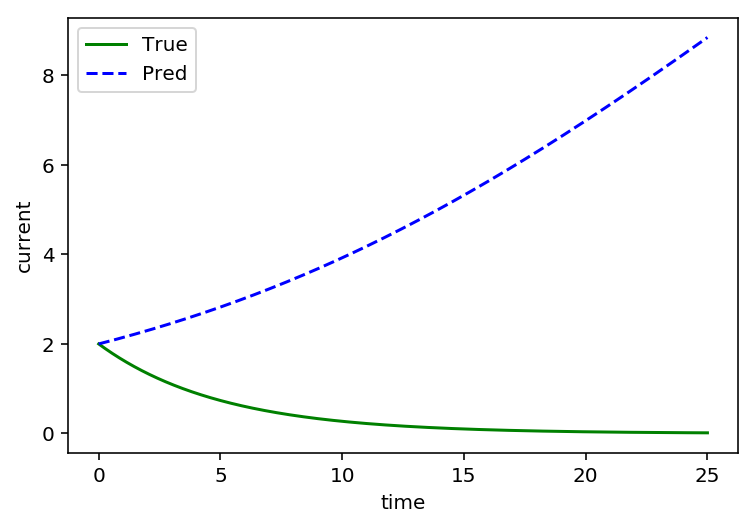

In [6]:
model = ODERegressionFunc()
model, y0, t, y_true = model.to(device), y0.to(device), t.to(device), y_true.to(device)
optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate)
end = time.time()

y_pred = odeint(model, y0, t)
plt.figure()
plt.xlabel('time')
plt.ylabel('current')
plt.plot(t.detach().cpu().numpy(), y_true.detach().cpu().numpy(), 'g-')
plt.plot(t.detach().cpu().numpy(), y_pred.detach().cpu().numpy(), 'b--')
plt.legend(['True', 'Pred'])

# Training

Iter 0000 | Total Loss 0.720124
Iter 0001 | Total Loss 0.715129
Iter 0002 | Total Loss 0.713932
Iter 0003 | Total Loss 0.710856
Iter 0004 | Total Loss 0.709073
Iter 0005 | Total Loss 0.705636
Iter 0006 | Total Loss 0.699332
Iter 0007 | Total Loss 0.693316
Iter 0008 | Total Loss 0.691706
Iter 0009 | Total Loss 0.688286
Iter 0010 | Total Loss 0.679803
Iter 0011 | Total Loss 0.681628
Iter 0012 | Total Loss 0.677530
Iter 0013 | Total Loss 0.675545
Iter 0014 | Total Loss 0.672659
Iter 0015 | Total Loss 0.671777
Iter 0016 | Total Loss 0.665190
Iter 0017 | Total Loss 0.663148
Iter 0018 | Total Loss 0.656894
Iter 0019 | Total Loss 0.650501
Iter 0020 | Total Loss 0.645812
Iter 0021 | Total Loss 0.645458
Iter 0022 | Total Loss 0.636834
Iter 0023 | Total Loss 0.634053
Iter 0024 | Total Loss 0.626986
Iter 0025 | Total Loss 0.626246
Iter 0026 | Total Loss 0.624598
Iter 0027 | Total Loss 0.620110
Iter 0028 | Total Loss 0.614400
Iter 0029 | Total Loss 0.611566
Iter 0030 | Total Loss 0.611994
Iter 003

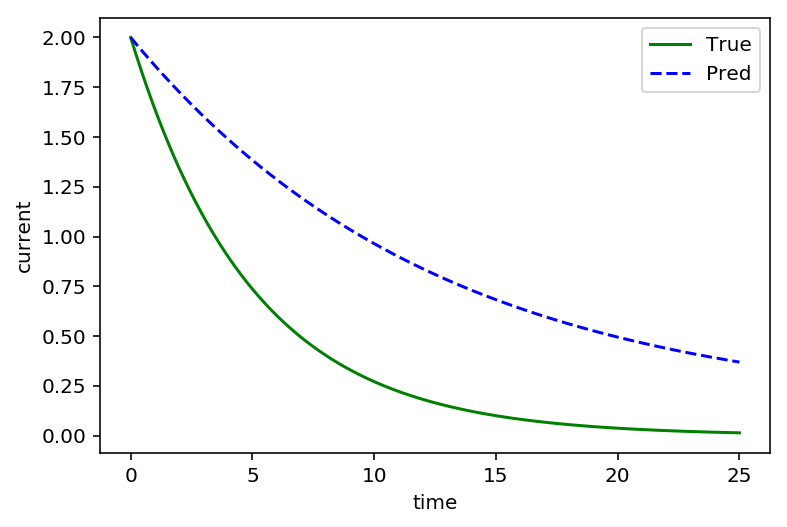

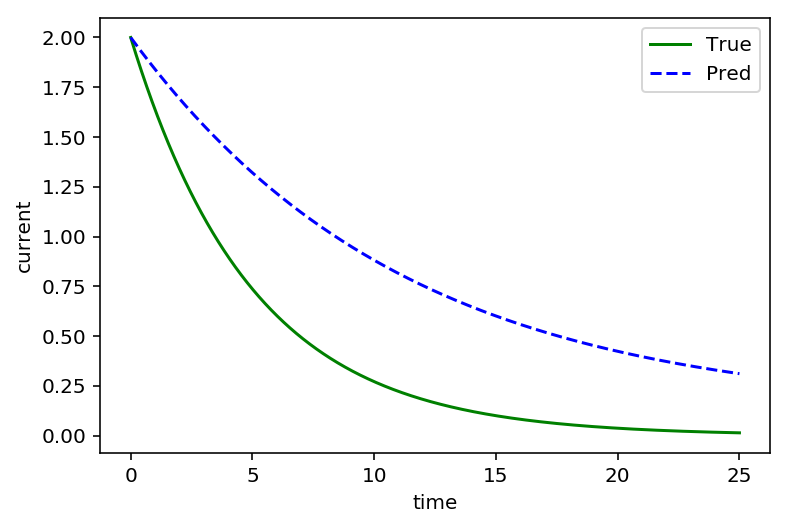

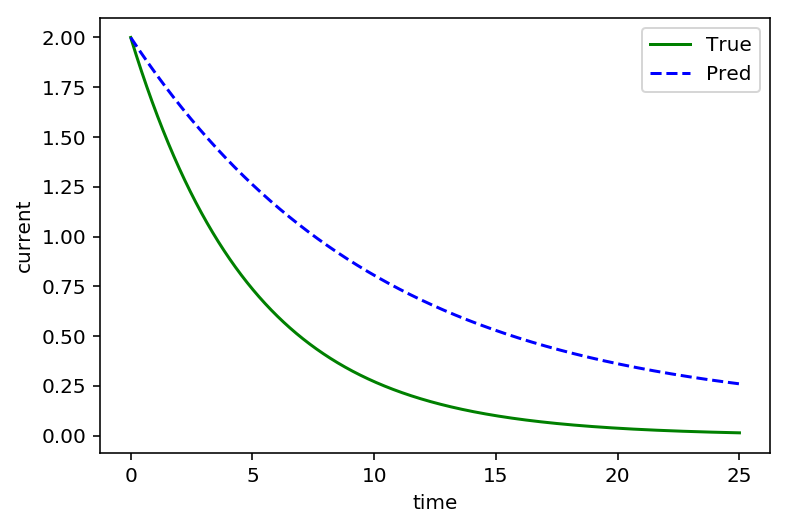

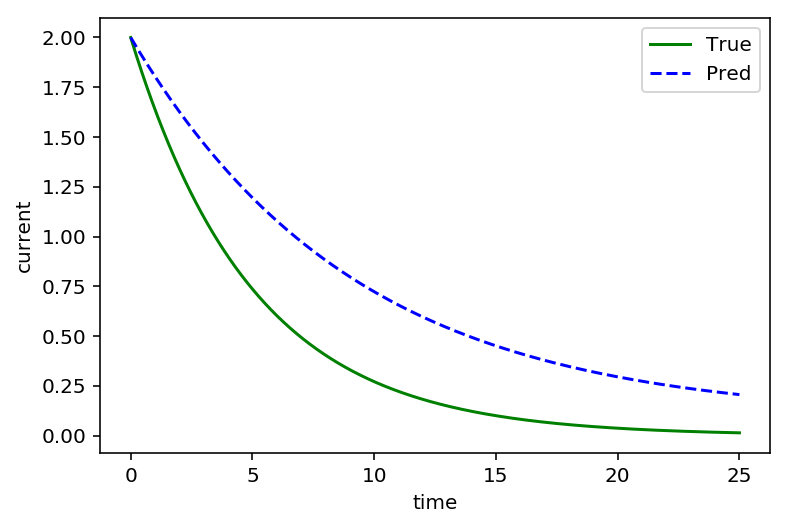

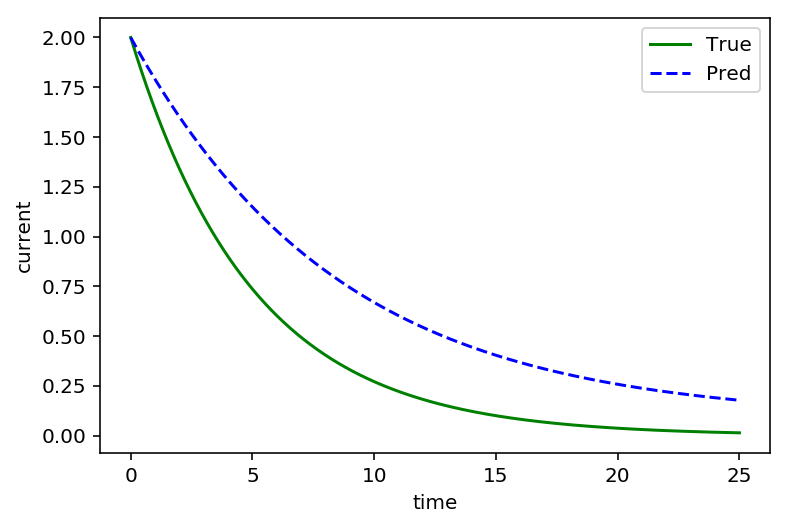

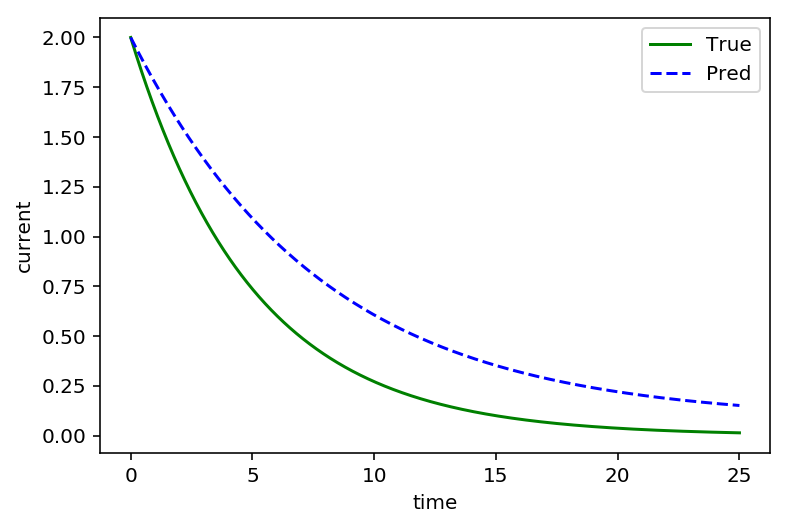

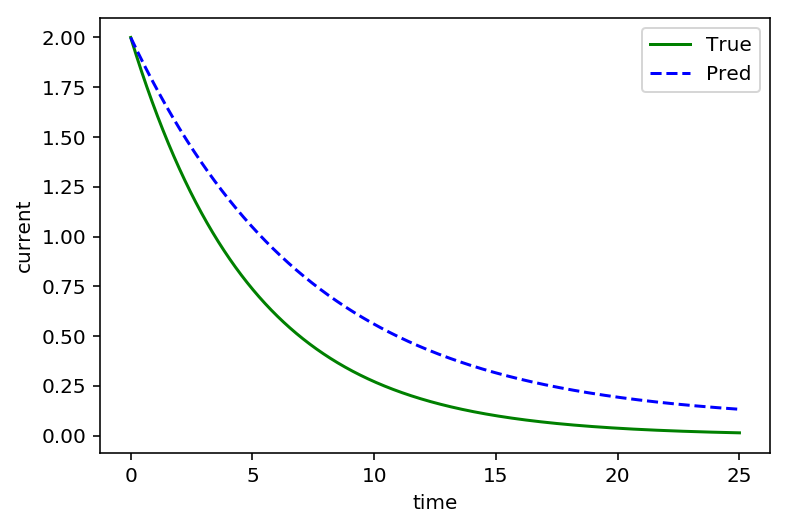

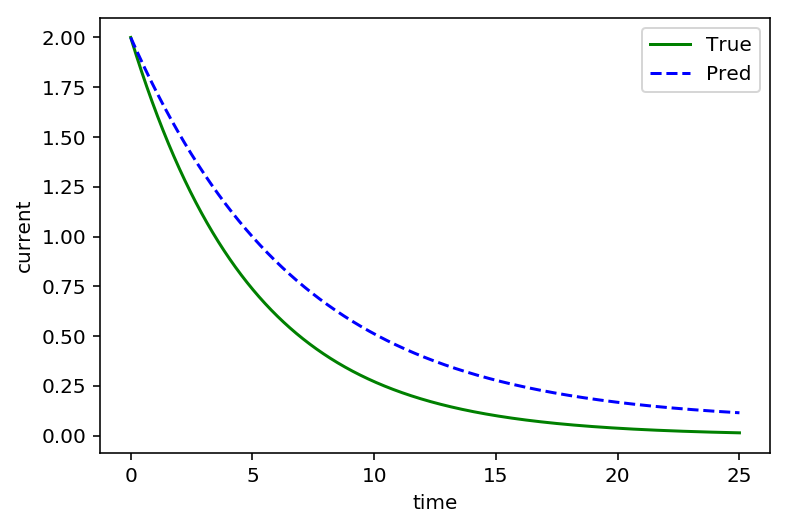

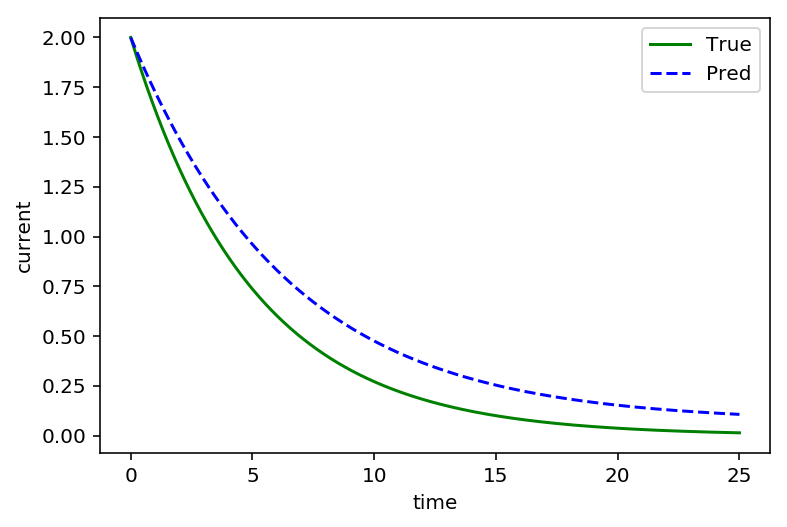

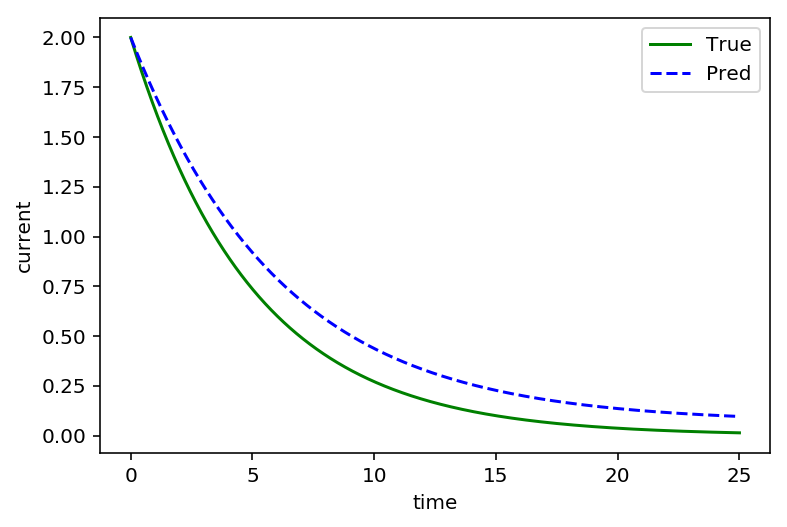

In [8]:
for itr in range(0, num_epochs):
    optimizer.zero_grad()
    batch_y0, batch_t, batch_y = get_batch()
    batch_y0, batch_t, batch_y = batch_y0.to(device), batch_t.to(device), batch_y.to(device)
    # Solve the ODE with initial condition batch_y0 and timesteps batch_t
    y_pred = odeint(model, batch_y0, batch_t)
    loss = torch.mean(torch.abs(y_pred - y_true))
    loss.backward()
    optimizer.step()
    
    with torch.no_grad():
        y_pred = odeint(model, y0, t)
        loss = torch.mean(torch.abs(y_pred - y_true))
        print('Iter {:04d} | Total Loss {:.6f}'.format(itr, loss.item()))
        if itr % 10 == 0:
            plt.figure()
            plt.title('True vs Predicted Function Iter {} Loss {}'.format(itr, loss.item()))
            plt.xlabel('time')
            plt.ylabel('current')
            plt.plot(t.detach().cpu().numpy(), y_true.detach().cpu().numpy(), 'g-')
            plt.plot(t.detach().cpu().numpy(), y_pred.detach().cpu().numpy(), 'b--')
            plt.legend(['True', 'Pred'])

    end = time.time()